# 2kr Assumptions Tests

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

## Config

In [2]:
inputFile = '2kr.csv'
repetitionsCount = -1 # -1 = auto-detect
factors = ['R', 'T', 'm', 'D']

showConstructedDF = True

# Fitting
distsFit = ['norm', 'uniform'] # Distributions to fit
distsParams = [(), ()] # Distributions params
outlierStddevDistance = 3 # Outliers identification

# Plots
histBinNum = 30 # Histograms
histCenter = True # Center distribution
plotSize = (10, 10)
plotStyle = 'seaborn-whitegrid'
scatterShowLines = False
# Save
saveFigures = False

# Filter scalars
scalarsFilter = ['Floorplan.userCount', 'Floorplan.coveredUsers:sum', 'Floorplan.collisions:sum']
# Filter vectors
vectorsFilter = ['Floorplan.coveredUsers:vector']
# Percentiles
percentiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95]

# Residuals to compute
residualNames = [
    ('coveredUsersPercent', 'percentage of covered users (residuals)'),
    ('collisions', 'total number of collisions (residuals)'),
]

intPercentiles = [int(i*100) for i in percentiles]
vecPerfIndexes = []
for intPercentile in intPercentiles:
    vecPerfIndexes.append(('broadcastTime' + str(intPercentile), 'Broadcast time needed to reach the ' + str(intPercentile) + 'th percentile of the coverage'))
for i, d in vecPerfIndexes:
    residualNames.append((i, d + ' (residuals)'))

## Load scalars

In [3]:
df = pd.read_csv('exported_data/' + inputFile, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray,
})

In [4]:
if repetitionsCount <= 0: # auto-detect
    repetitionsCount = int(df[df.attrname == 'repetition']['attrvalue'].max()) + 1
print('Repetitions:', repetitionsCount)

# Computed
factorsCount = len(factors)
configsCount = 2**factorsCount
totalSims = configsCount*repetitionsCount

# Scatter plot whitelists
configsShown = range(0, configsCount)
repetitionsShown = range(0, repetitionsCount)


display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))
pd.set_option('display.max_rows', totalSims)
if saveFigures:
    os.makedirs('figures', exist_ok=True)

Repetitions: 10


In [5]:
scalars = df[(df.type == 'scalar') | ((df.type == 'itervar') & (df.attrname != 'TO')) | ((df.type == 'param') & (df.attrname == 'Floorplan.userCount')) | ((df.type == 'runattr') & (df.attrname == 'repetition'))]
scalars = scalars.assign(qname = scalars.attrname.combine_first(scalars.module + '.' + scalars.name))
scalars.value = scalars.value.combine_first(scalars.attrvalue.astype('float64'))
scalars_wide = scalars.pivot_table(index=['run'], columns='qname', values='value')
scalars_wide.sort_values([*factors, 'repetition'], inplace=True)
count = 0
for index in scalars_wide.index:
    config = count // repetitionsCount
    scalars_wide.loc[index, 'config'] = config
    count += 1
scalars_wide = scalars_wide[['config', 'repetition', *factors, *scalarsFilter]]

# coverage
scalars_wide['coveredUsersPercent'] = scalars_wide['Floorplan.coveredUsers:sum'] / (scalars_wide['Floorplan.userCount'] - 1)

## Load vectors

In [6]:
vectors = df[df.type == 'vector']
vectors = vectors.assign(qname = vectors.module + '.' + vectors.name)
for index in scalars_wide.index:
    r = index
    cfg = scalars_wide.loc[index, 'config']
    rep = scalars_wide.loc[index, 'repetition']
    vectors.loc[vectors.run == r, 'config'] = cfg
    vectors.loc[vectors.run == r, 'repetition'] = rep
vectors = vectors[vectors.qname.isin(vectorsFilter)]
vectors.sort_values(['config', 'repetition', 'qname'], inplace=True)
vectors = vectors[['config', 'repetition', 'qname', 'vectime', 'vecvalue']]

## Compute scalars from vectors

In [7]:
def get_percentile(percentile, vectime, vecvalue, totalvalue):
    tofind = percentile * totalvalue
    idx = 0
    csum = vecvalue.cumsum()
    for value in csum:
        if value >= tofind:
            return vectime[idx]
        idx += 1
    return math.inf

for index, row in vectors.iterrows():
    for vecPerf, percentile in zip(vecPerfIndexes, percentiles):
        vecPerfIndex = vecPerf[0]
        cfg = row['config']
        rep = row['repetition']
        users = scalars_wide[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep)]['Floorplan.userCount'].values[0] - 1
        value = get_percentile(percentile, row['vectime'], row['vecvalue'], users)
        scalars_wide.loc[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep), vecPerfIndex] = value

## Compute residuals

In [8]:
# coverage
scalars_wide['coveredUsersPercentMean'] = scalars_wide.groupby(factors)['coveredUsersPercent'].transform('mean')
scalars_wide['coveredUsersPercentResidual'] = scalars_wide['coveredUsersPercent'] - scalars_wide['coveredUsersPercentMean']

# collisions
scalars_wide['collisionsMean'] = scalars_wide.groupby(factors)['Floorplan.collisions:sum'].transform('mean')
scalars_wide['collisionsResidual'] = scalars_wide['Floorplan.collisions:sum'] - scalars_wide['collisionsMean']

# vectors
skipped = []
for vecPerfIndex, _ in vecPerfIndexes:
    mean = scalars_wide.groupby(factors)[vecPerfIndex].transform('mean')
    nextVect = False
    for value in mean.values:
        if math.isinf(value):
            skipped.append(vecPerfIndex)
            nextVect = True
            continue
    if nextVect:
        continue
    scalars_wide[vecPerfIndex + 'Mean'] = mean
    scalars_wide[vecPerfIndex + 'Residual'] = scalars_wide[vecPerfIndex] - scalars_wide[vecPerfIndex + 'Mean']
for i, d in vecPerfIndexes:
    if i not in skipped:
        continue
    print(i + ' skipped due to infinite values in observations')
    residualNames.remove((i, d + ' (residuals)'))

broadcastTime50 skipped due to infinite values in observations
broadcastTime75 skipped due to infinite values in observations
broadcastTime90 skipped due to infinite values in observations
broadcastTime95 skipped due to infinite values in observations


## Constructed DataFrame

In [9]:
if showConstructedDF:
    display(scalars_wide.describe())
    display(scalars_wide[(totalSims//2)-10:(totalSims//2)+10])
else:
    print('Skipping...')

qname,config,repetition,R,T,m,D,Floorplan.userCount,Floorplan.coveredUsers:sum,Floorplan.collisions:sum,coveredUsersPercent,...,broadcastTime90,broadcastTime95,coveredUsersPercentMean,coveredUsersPercentResidual,collisionsMean,collisionsResidual,broadcastTime10Mean,broadcastTime10Residual,broadcastTime25Mean,broadcastTime25Residual
count,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.0,160.000000,160.000000,160.000000,...,160.00,160.0,160.000000,1.600000e+02,160.000000,1.600000e+02,160.000000,1.600000e+02,160.000000,1.600000e+02
mean,7.500000,4.500000,20.000000,3.000000,3.000000,3.000000,500.0,443.450000,882.275000,0.888677,...,inf,inf,0.888677,1.838807e-17,882.275000,-1.278977e-14,6.475000,-1.026956e-16,13.900000,1.443290e-16
std,4.624246,2.881299,10.031397,2.006279,2.006279,2.006279,0.0,59.709443,644.252226,0.119658,...,NaN,NaN,0.104142,5.892829e-02,624.994276,1.563428e+02,6.489227,2.226767e+00,12.260023,6.077798e+00
min,0.000000,0.000000,10.000000,1.000000,1.000000,1.000000,500.0,191.000000,129.000000,0.382766,...,11.00,15.0,0.633868,-2.511022e-01,175.200000,-5.697000e+02,1.000000,-7.600000e+00,2.300000,-1.890000e+01
25%,3.750000,2.000000,10.000000,1.000000,1.000000,1.000000,500.0,408.750000,336.000000,0.819138,...,31.75,49.5,0.838727,-1.422846e-02,343.375000,-3.732500e+01,1.000000,-4.250000e-01,3.725000,-2.600000e+00
50%,7.500000,4.500000,20.000000,3.000000,3.000000,3.000000,500.0,456.500000,664.000000,0.914830,...,100.00,inf,0.909719,9.018036e-04,685.450000,2.100000e+00,3.800000,0.000000e+00,9.650000,-4.000000e-01
75%,11.250000,7.000000,30.000000,5.000000,5.000000,5.000000,500.0,490.250000,1223.500000,0.982465,...,inf,inf,0.977355,1.908818e-02,1331.900000,3.980000e+01,9.475000,0.000000e+00,17.075000,1.625000e+00
max,15.000000,9.000000,30.000000,5.000000,5.000000,5.000000,500.0,499.000000,2565.000000,1.000000,...,inf,inf,1.000000,2.619238e-01,2131.800000,5.388000e+02,18.000000,1.000000e+01,39.400000,4.010000e+01


qname,config,repetition,R,T,m,D,Floorplan.userCount,Floorplan.coveredUsers:sum,Floorplan.collisions:sum,coveredUsersPercent,...,broadcastTime90,broadcastTime95,coveredUsersPercentMean,coveredUsersPercentResidual,collisionsMean,collisionsResidual,broadcastTime10Mean,broadcastTime10Residual,broadcastTime25Mean,broadcastTime25Residual
run,,,,,,,,,,,,,,,,,,,,,
HighDensity2kr-140-20210204-12:58:44-18780,7.0,0.0,10.0,5.0,5.0,5.0,500.0,499.0,389.0,1.000000,...,62.0,74.0,1.000000,0.000000,403.2,-14.2,16.2,-3.2,30.5,-9.5
HighDensity2kr-141-20210204-12:58:44-18780,7.0,1.0,10.0,5.0,5.0,5.0,500.0,499.0,370.0,1.000000,...,87.0,93.0,1.000000,0.000000,403.2,-33.2,16.2,-2.2,30.5,1.5
HighDensity2kr-142-20210204-12:58:45-18780,7.0,2.0,10.0,5.0,5.0,5.0,500.0,499.0,416.0,1.000000,...,75.0,79.0,1.000000,0.000000,403.2,12.8,16.2,-3.2,30.5,-6.5
HighDensity2kr-143-20210204-12:58:45-18780,7.0,3.0,10.0,5.0,5.0,5.0,500.0,499.0,363.0,1.000000,...,71.0,75.0,1.000000,0.000000,403.2,-40.2,16.2,-0.2,30.5,-2.5
HighDensity2kr-144-20210204-12:58:45-18780,7.0,4.0,10.0,5.0,5.0,5.0,500.0,499.0,452.0,1.000000,...,70.0,77.0,1.000000,0.000000,403.2,48.8,16.2,-3.2,30.5,-5.5
HighDensity2kr-145-20210204-12:58:46-18780,7.0,5.0,10.0,5.0,5.0,5.0,500.0,499.0,397.0,1.000000,...,97.0,103.0,1.000000,0.000000,403.2,-6.2,16.2,4.8,30.5,10.5
HighDensity2kr-146-20210204-12:58:46-18780,7.0,6.0,10.0,5.0,5.0,5.0,500.0,499.0,374.0,1.000000,...,52.0,60.0,1.000000,0.000000,403.2,-29.2,16.2,-3.2,30.5,-9.5
HighDensity2kr-147-20210204-12:58:47-18780,7.0,7.0,10.0,5.0,5.0,5.0,500.0,499.0,444.0,1.000000,...,89.0,92.0,1.000000,0.000000,403.2,40.8,16.2,3.8,30.5,9.5
HighDensity2kr-148-20210204-12:58:47-18780,7.0,8.0,10.0,5.0,5.0,5.0,500.0,499.0,411.0,1.000000,...,62.0,65.0,1.000000,0.000000,403.2,7.8,16.2,-1.2,30.5,-5.5


## Residual distributions (histograms)

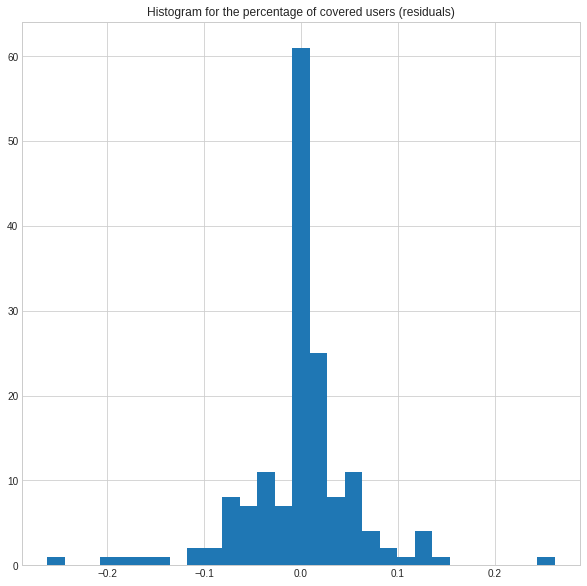

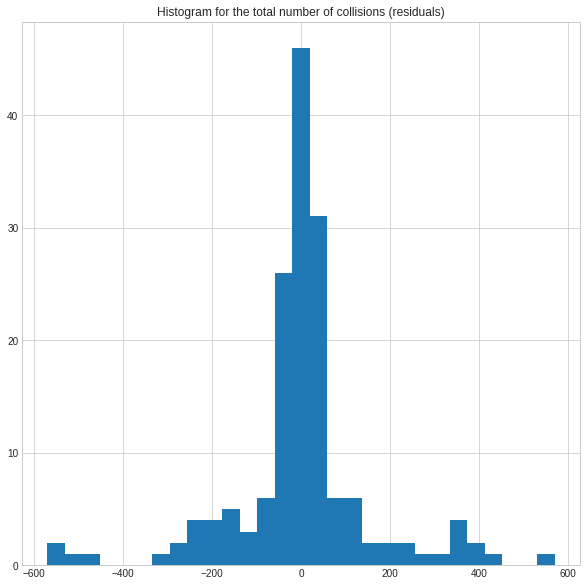

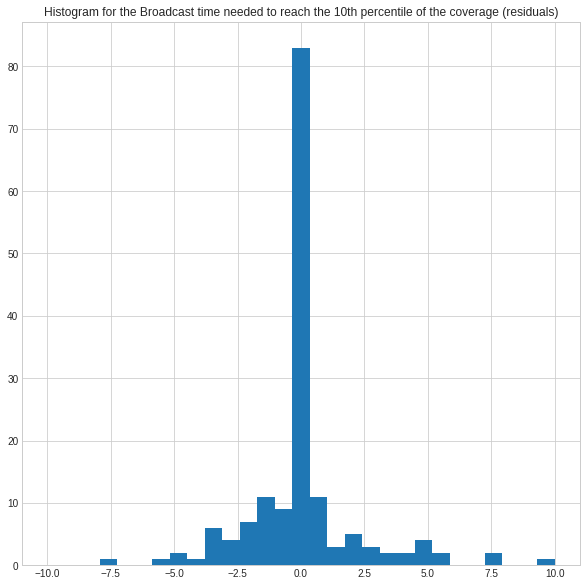

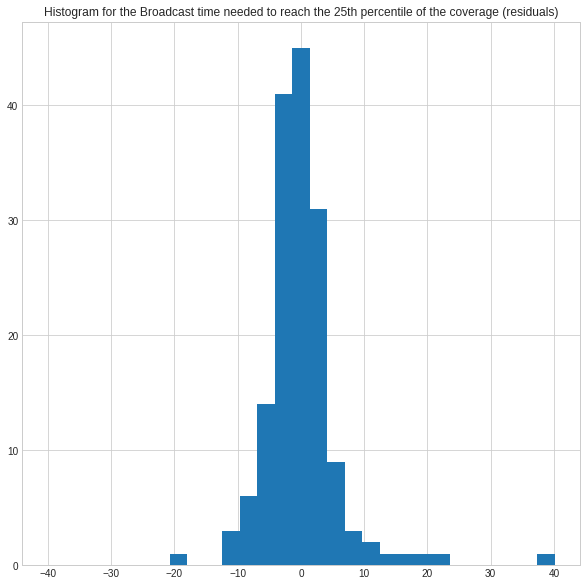

In [10]:
for varname, vardesc in residualNames:
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    minval = scalars_wide[varname + 'Residual'].min()
    maxval = scalars_wide[varname + 'Residual'].max()
    if histCenter:
        limit = max(abs(minval), abs(maxval))
        minval = -limit
        maxval = limit
    plt.hist(scalars_wide[varname + 'Residual'].values.tolist(), bins=np.linspace(minval, maxval, histBinNum))
    plt.title('Histogram for the ' + vardesc)
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + varname + '-hist.png')
    plt.show()

## Distribution fitting

Trying to fit to a norm distribution:


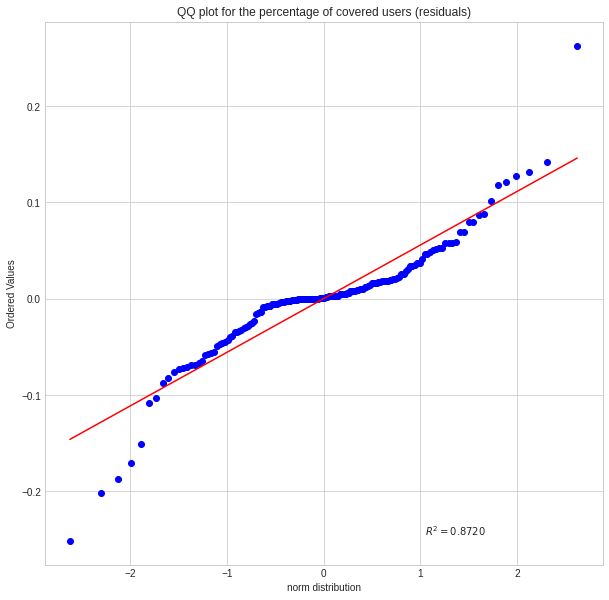

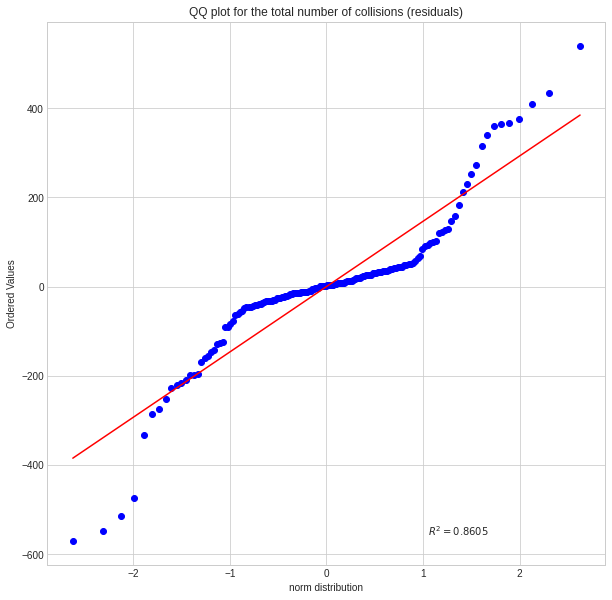

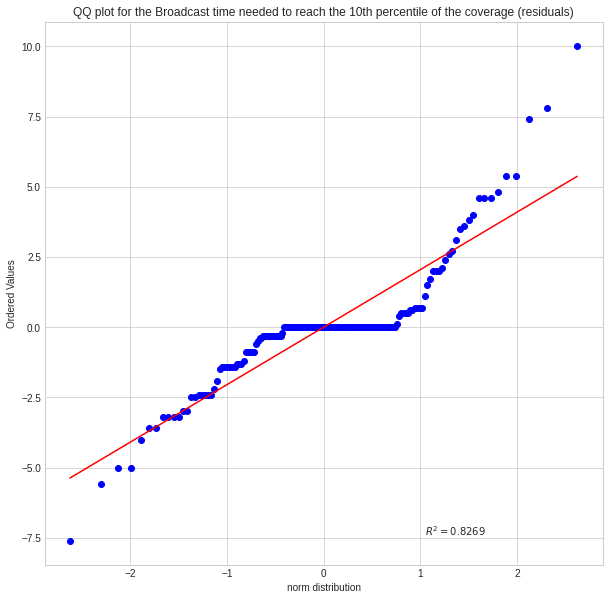

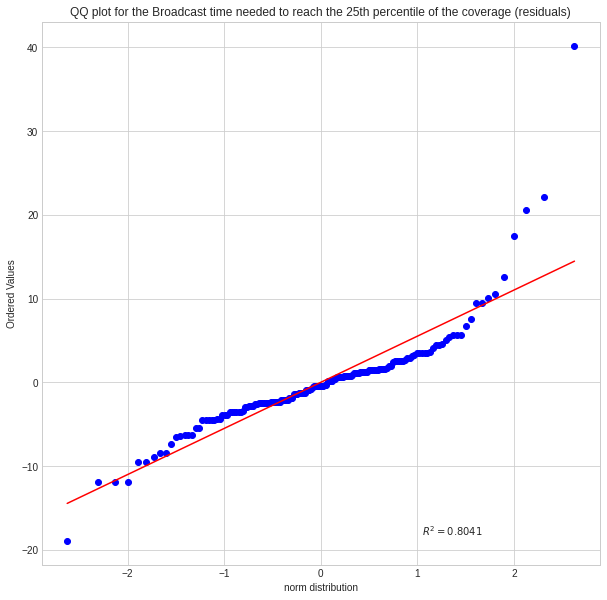

Trying to fit to a uniform distribution:


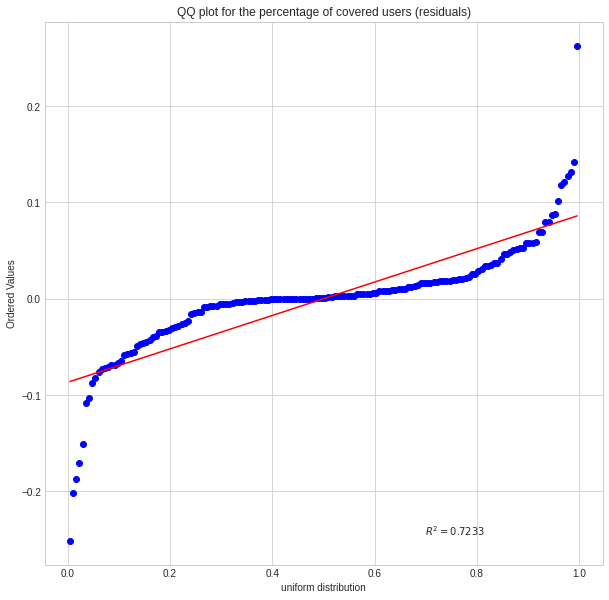

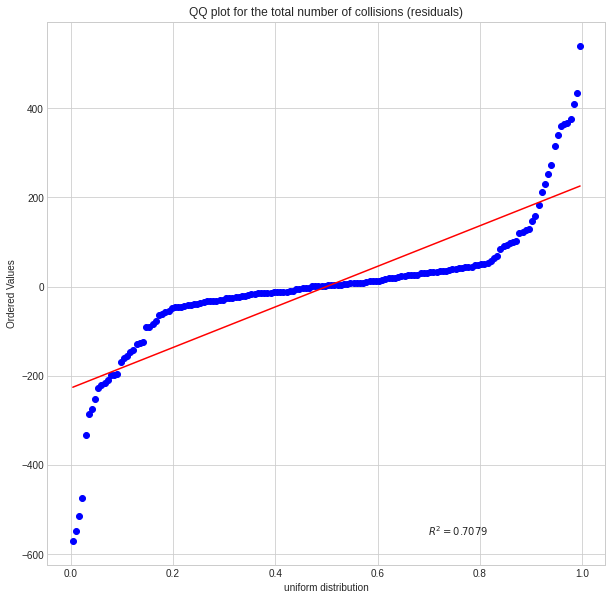

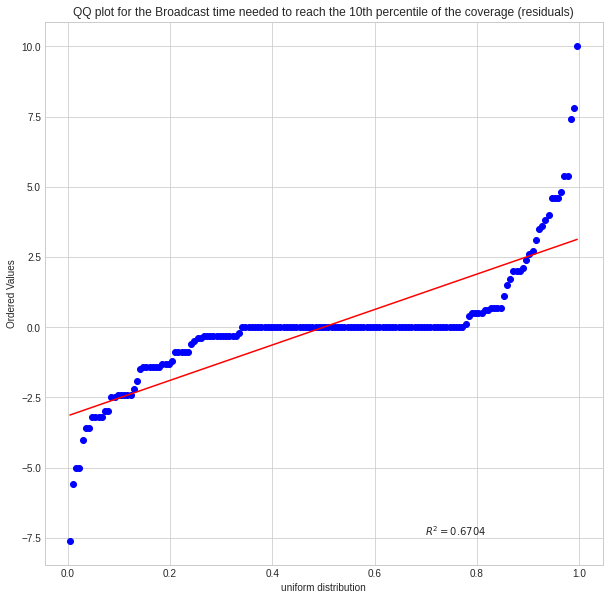

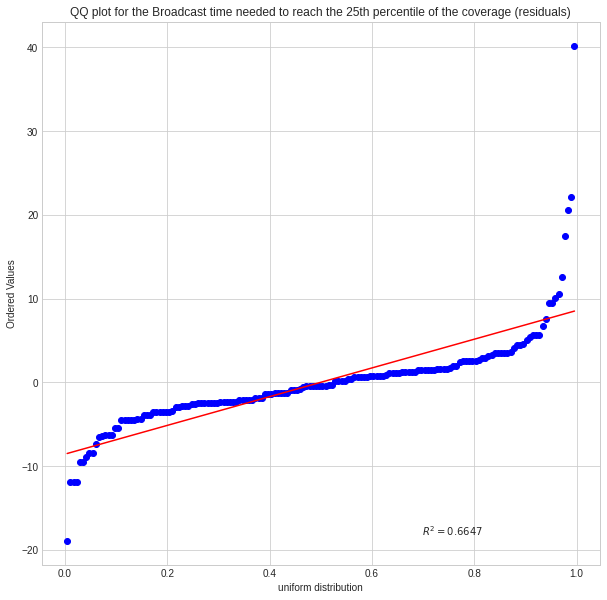

In [11]:
for distribution, params in zip(distsFit, distsParams):
    print('Trying to fit to a', distribution + ('({})'.format(', '.join(map(str, params))) if len(params) > 0 else ''), 'distribution:')
    for varname, vardesc in residualNames:
        plt.figure(figsize=plotSize)
        plt.style.use(plotStyle)
        residuals = scalars_wide[varname + 'Residual'].values.tolist()
        result, line = stats.probplot(residuals, dist=distribution, sparams=params, plot=plt, rvalue=True)
        #osm, _ = result
        #slope, intercept, _ = line
        plt.title("QQ plot for the " + vardesc)
        plt.xlabel(distribution + " distribution")
        if saveFigures:
            fig = plt.gcf()
            fig.savefig('figures/' + varname + '-' + distribution + '-fit.png')
        plt.show()

### Outliers

In [12]:
for varname, vardesc in residualNames:
    print('Outliers for the ' + vardesc)
    stddev = scalars_wide[varname + 'Residual'].std()
    limit = outlierStddevDistance*stddev
    print('total mean:', scalars_wide[varname + 'Mean'].mean())
    print('stddev:', stddev)
    print(str(outlierStddevDistance) + '*stddev:', limit)
    outliers = scalars_wide[np.abs(scalars_wide[varname + 'Residual']) > limit]
    display(outliers[['config', 'repetition', *factors, varname + 'Residual', varname + 'Mean']])

Outliers for the percentage of covered users (residuals)
total mean: 0.8886773547094183
stddev: 0.05892828648694976
3*stddev: 0.1767848594608493


qname,config,repetition,R,T,m,D,coveredUsersPercentResidual,coveredUsersPercentMean
run,,,,,,,,
HighDensity2kr-3-20210204-12:58:08-18780,0.0,3.0,10.0,1.0,1.0,1.0,-0.201603,0.846894
HighDensity2kr-13-20210204-12:58:09-18780,8.0,3.0,30.0,1.0,1.0,1.0,-0.251102,0.633868
HighDensity2kr-15-20210204-12:58:09-18780,8.0,5.0,30.0,1.0,1.0,1.0,0.261924,0.633868
HighDensity2kr-35-20210204-12:58:16-18780,10.0,5.0,30.0,1.0,5.0,1.0,-0.187174,0.776353


Outliers for the total number of collisions (residuals)
total mean: 882.275
stddev: 156.34284612540222
3*stddev: 469.02853837620665


qname,config,repetition,R,T,m,D,collisionsResidual,collisionsMean
run,,,,,,,,
HighDensity2kr-31-20210204-12:58:15-18780,10.0,1.0,30.0,1.0,5.0,1.0,-473.2,1566.2
HighDensity2kr-32-20210204-12:58:15-18780,10.0,2.0,30.0,1.0,5.0,1.0,-549.2,1566.2
HighDensity2kr-33-20210204-12:58:15-18780,10.0,3.0,30.0,1.0,5.0,1.0,-515.2,1566.2
HighDensity2kr-35-20210204-12:58:16-18780,10.0,5.0,30.0,1.0,5.0,1.0,538.8,1566.2
HighDensity2kr-114-20210204-12:58:38-18780,14.0,4.0,30.0,5.0,5.0,1.0,-569.7,1564.7


Outliers for the Broadcast time needed to reach the 10th percentile of the coverage (residuals)
total mean: 6.475
stddev: 2.226766841417785
3*stddev: 6.680300524253354


qname,config,repetition,R,T,m,D,broadcastTime10Residual,broadcastTime10Mean
run,,,,,,,,
HighDensity2kr-86-20210204-12:58:30-18780,4.0,6.0,10.0,5.0,1.0,1.0,10.0,18.0
HighDensity2kr-123-20210204-12:58:41-18780,5.0,3.0,10.0,5.0,1.0,5.0,-7.6,17.6
HighDensity2kr-125-20210204-12:58:41-18780,5.0,5.0,10.0,5.0,1.0,5.0,7.4,17.6
HighDensity2kr-149-20210204-12:58:47-18780,7.0,9.0,10.0,5.0,5.0,5.0,7.8,16.2


Outliers for the Broadcast time needed to reach the 25th percentile of the coverage (residuals)
total mean: 13.899999999999997
stddev: 6.077797515672055
3*stddev: 18.233392547016166


qname,config,repetition,R,T,m,D,broadcastTime25Residual,broadcastTime25Mean
run,,,,,,,,
HighDensity2kr-86-20210204-12:58:30-18780,4.0,6.0,10.0,5.0,1.0,1.0,20.6,39.4
HighDensity2kr-124-20210204-12:58:41-18780,5.0,4.0,10.0,5.0,1.0,5.0,22.1,38.9
HighDensity2kr-125-20210204-12:58:41-18780,5.0,5.0,10.0,5.0,1.0,5.0,40.1,38.9
HighDensity2kr-126-20210204-12:58:41-18780,5.0,6.0,10.0,5.0,1.0,5.0,-18.9,38.9


## Independency test

qname,config,R,T,m,D
run,,,,,
HighDensity2kr-0-20210204-12:58:07-18780,0.0,10.0,1.0,1.0,1.0
HighDensity2kr-40-20210204-12:58:18-18780,1.0,10.0,1.0,1.0,5.0
HighDensity2kr-20-20210204-12:58:10-18780,2.0,10.0,1.0,5.0,1.0
HighDensity2kr-60-20210204-12:58:22-18780,3.0,10.0,1.0,5.0,5.0
HighDensity2kr-80-20210204-12:58:29-18780,4.0,10.0,5.0,1.0,1.0
HighDensity2kr-120-20210204-12:58:40-18780,5.0,10.0,5.0,1.0,5.0
HighDensity2kr-100-20210204-12:58:33-18780,6.0,10.0,5.0,5.0,1.0
HighDensity2kr-140-20210204-12:58:44-18780,7.0,10.0,5.0,5.0,5.0
HighDensity2kr-10-20210204-12:58:09-18780,8.0,30.0,1.0,1.0,1.0


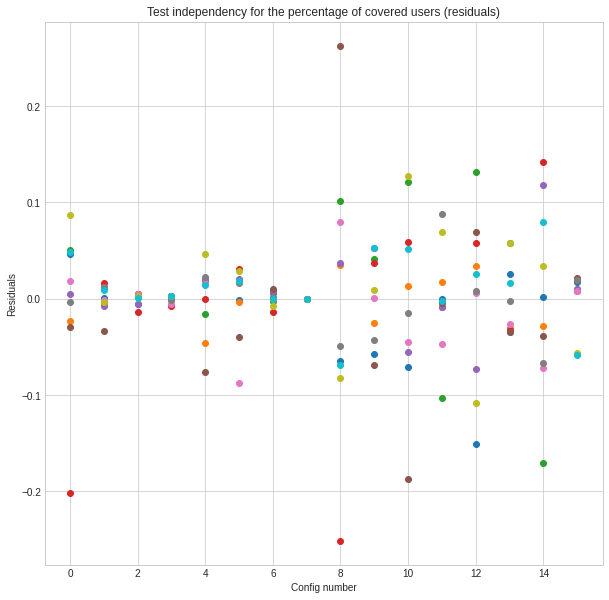

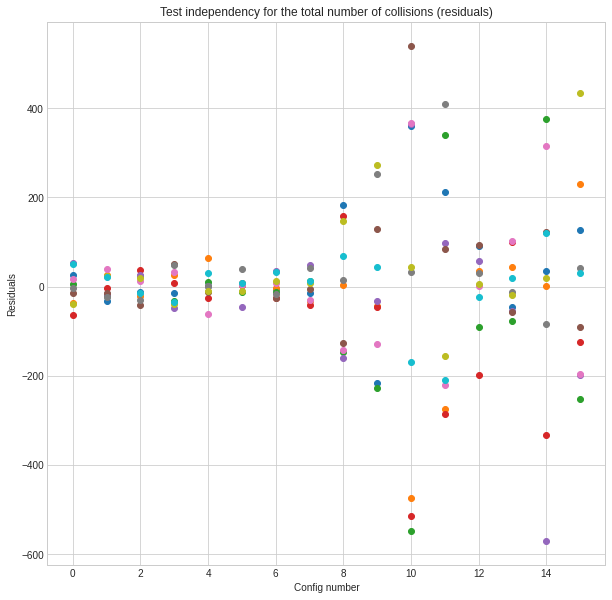

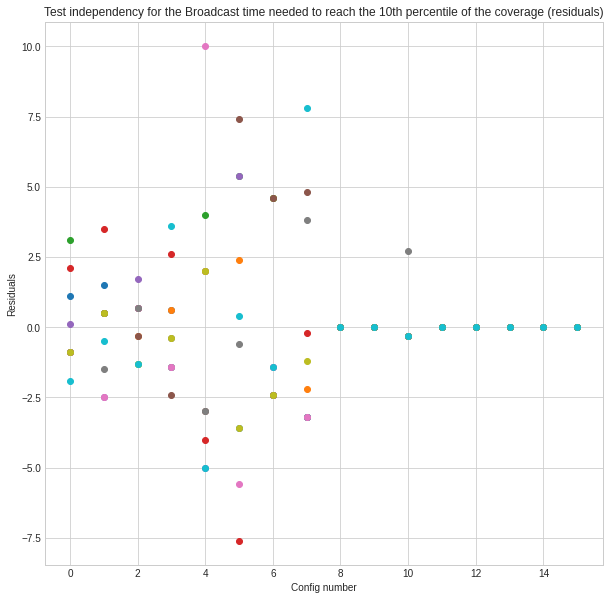

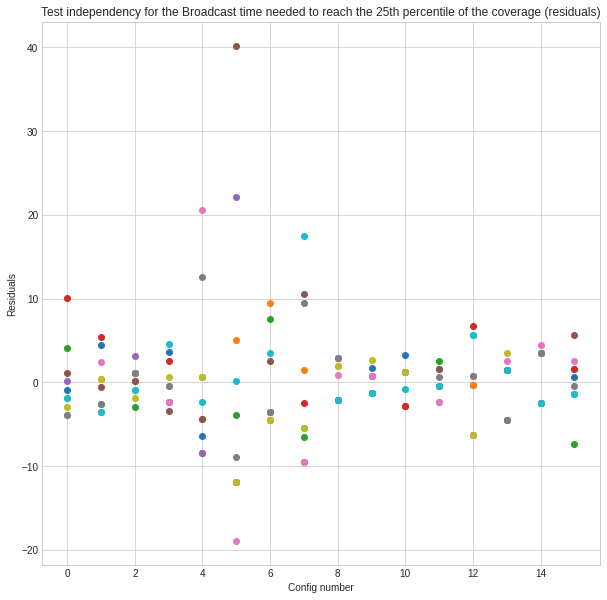

In [13]:
display(scalars_wide.loc[(scalars_wide.repetition == 0) & (scalars_wide.config.isin(configsShown))][['config', *factors]])
for varname, vardesc in residualNames:
    y = []
    x = []
    for config in range(0, configsCount):
        if config not in configsShown:
            continue
        x.append([config] * len(repetitionsShown))
        y.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Residual'].values.tolist())
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    plt.plot(x, y, 'o' + ('-' if scatterShowLines else ''))
    plt.title("Test independency for the " + vardesc)
    plt.xlabel("Config number")
    plt.ylabel("Residuals")
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + varname + '-independency.png')
    plt.show()

## Finite variance test

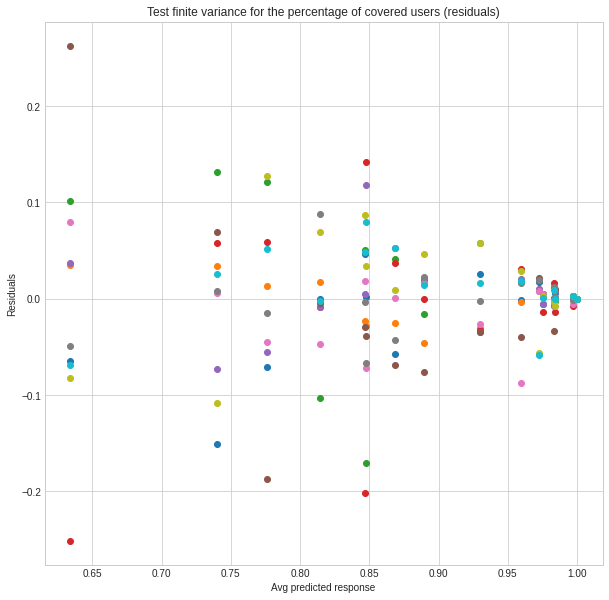

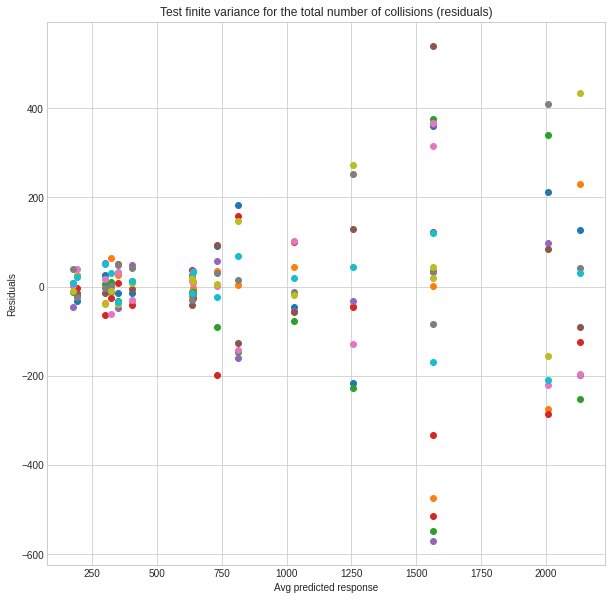

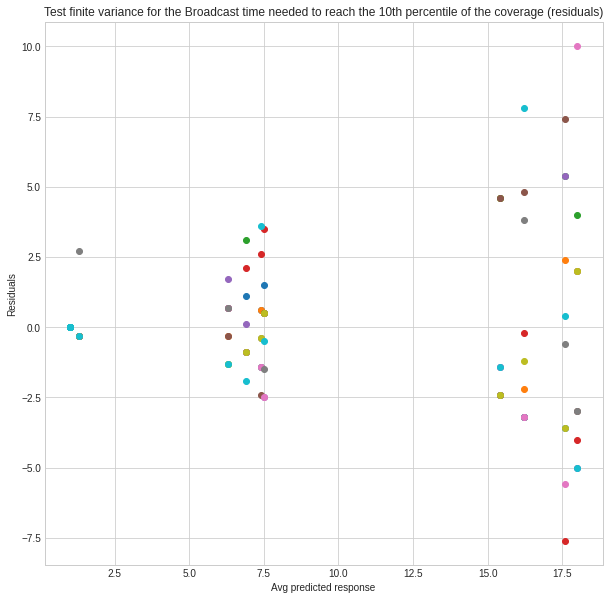

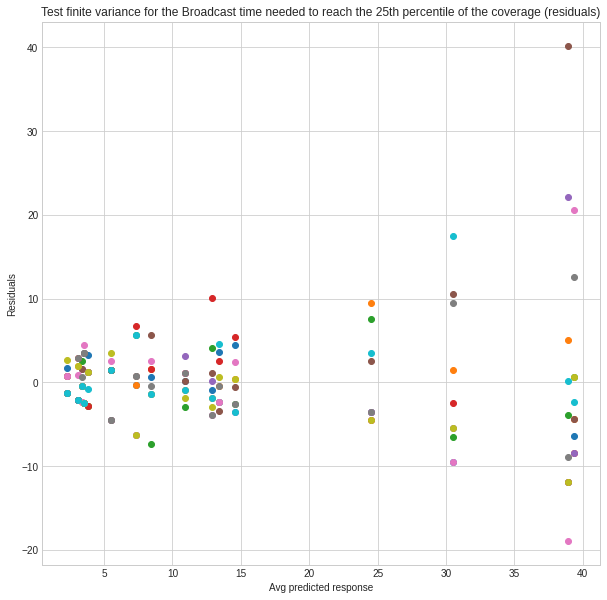

In [14]:
for varname, vardesc in residualNames:
    y = []
    x = []
    for config in range(0, configsCount):
        if config not in configsShown:
            continue
        x.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Mean'].values.tolist())
        y.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Residual'].values.tolist())
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    plt.plot(x, y, 'o' + ('-' if scatterShowLines else ''))
    plt.title("Test finite variance for the " + vardesc)
    plt.xlabel("Avg predicted response")
    plt.ylabel("Residuals")
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + varname + '-variance.png')
    plt.show()